In [1]:
import numpy as np
import pandas as pd
import random 
import time 
from scipy.integrate import solve_ivp
from scipy.optimize import dual_annealing

In [24]:
# ------------------------------------------------------------------
# 1.  Data — replace with your own cumulative case matrix
# ------------------------------------------------------------------
cases = pd.read_csv("/Users/boyapeng/Desktop/Dissertation/Aim1/Data/case_count.csv",header=0)

# Extract Date and Gaines, remove if NA
case_df = (
    cases[["Update Date", "Gaines"]]          # keep only the needed cols
         .loc[1:]
         .assign(
             Gaines=lambda d: pd.to_numeric(d["Gaines"], errors="coerce"),
             Date=lambda d: pd.to_datetime(d["Update Date"])
         )
         .dropna(subset=["Gaines"])           # drop rows where Gaines is NaN
         .set_index("Date")                   # set date as index
         .drop(columns="Update Date")         # drop redundant col
         .sort_index()
)

# Prepare the proportion dataframe
prop_path = "/Users/boyapeng/Desktop/Dissertation/Aim1/Data/case_age_prop_ext.csv"
prop_df   = pd.read_csv(prop_path)
prop_df.rename(columns={prop_df.columns[0]: "Date"}, inplace=True)
prop_df[["Prop_0-4", "Prop_5-17", "Prop_18+"]] = prop_df[
    ["Prop_0-4", "Prop_5-17", "Prop_18+"]
].astype(float)
prop_df["Date"] = pd.to_datetime(prop_df["Date"])
prop_df = prop_df.set_index("Date").sort_index()

# Ensure both dataframes cover the same dates
case_aligned = case_df.reindex(prop_df.index)

# Keep only dates where we have a real case count
valid_idx      = case_aligned["Gaines"].notna()   # Boolean mask
case_filtered  = case_aligned.loc[valid_idx]      # drop NaNs
prop_filtered  = prop_df.loc[valid_idx]           # keep matching rows

# Multiply to get age-stratified counts
case_counts = (
    case_filtered["Gaines"].to_numpy().reshape(-1, 1) *
    prop_filtered[["Prop_0-4", "Prop_5-17", "Prop_18+"]].to_numpy()
).round().astype(int).tolist() 
case_counts = np.array(case_counts)

# Time
date = case_df.index.to_series()
ts_cases = ((date - date.iloc[0]).dt.days + date.iloc[0].day).tolist()
ts_cases = np.array(ts_cases)

n_age = 3
n_obs = len(case_counts)

/var/folders/vy/m4l1bmcs7xd4nmd991yq7qkr0000gn/T/ipykernel_42913/1468431833.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Date=lambda d: pd.to_datetime(d["Update Date"])


In [3]:
N_raw = np.array([2341, 6500, 13682], dtype=int)   # population
V_raw = np.array([1988, 4536, 11616], dtype=int)   # one-dose total
E_raw = np.zeros(n_age, dtype=int)                 # exposed
I_raw = np.array([0, 1, 0], dtype=int)             # infectious

# Initialize y0 vector (length 10*n_age)
y0 = np.zeros(10 * n_age)

# Vaccination rate (daily proportion vaccinated)
v = 0.003

# Vaccine efficacy (leakey)
epsA = 1  
epsL = 0.97

# Exposed to infectious rate
sigma = float(np.random.gamma(shape=10, scale=1/80))

# Infectious to recovered rate
gamma1 = 1/3

# Underreporting rate
rep = 0.9

# Contact matrix (flattened row-major order) ##time-varying
C = np.array([
    1.4101, 2.5282, 4.9100,
    0.9290,11.0091, 6.0771,
    0.4884, 1.6387, 8.8461
])
C_flat = C.ravel(order="C")  

x_r = [v, epsA, epsL, sigma, gamma1, rep] + C.flatten(order='C').tolist()
x_i = [n_age] + N_raw.tolist() + V_raw.tolist() + E_raw.tolist() + I_raw.tolist()

In [10]:
# ------------------------------------------------------------------
# 2.  Deterministic SEIRHD ODE
# ------------------------------------------------------------------
def seirhd_ode(t, y, theta, x_r, x_i):
    """
    SEIRHD ODE with clearer indexing.

    Parameters
    ----------
    t : float
        Current time (unused but required by ODE solver signature).
    y : ndarray
        State vector ordered by age block:
            [S1, VS1, VR1, S2, V2, E, I, R, C] × n_age.
    theta : ndarray
        Age-specific β followed by scalar contact modifier:
            [β_0, …, β_{n_age−1}, con, (optional tail...)].
    x_r : ndarray
        Fixed real parameters:
            [v, epsA, epsL, sigma, gamma1, rep, *Cflat*].
    x_i : ndarray
        Fixed integer parameters:
            [n_age, N_pop_0, …, N_pop_{n_age−1}].
    """
    n_age = int(x_i[0])

    beta = np.asarray(theta[:n_age], dtype=float)  # β per age
    con  = float(theta[n_age])                    # contact modifier

    v, epsA, epsL, sigma, gamma1, rep = x_r[:6]
    Cmat = np.reshape(x_r[6:], (n_age, n_age))    # contact matrix

    N_pop = np.asarray(x_i[1:1 + n_age], dtype=float)

    dydt = np.zeros_like(y)

    for i in range(n_age):
        idx = i * 9
        S1, VS1, VR1, S2, V2, E, I, R, C = y[idx : idx + 9]

        # Force of infection λ_i
        lam_i = 0.0
        for j in range(n_age):
            jdx = j * 9
            Ij  = max(y[jdx + 6], 0.0)
            Nj  = N_pop[j] - y[jdx + 3] - y[jdx + 4]  # exclude protected
            lam_i += Cmat[i, j] * Ij / Nj

        lam   = beta[i] * lam_i
        v_eff = v if i == 0 else 0.0  # adjust if vaccination varies by age

        # Compartment flows
        dydt[idx + 0] = -lam * S1 - v_eff * S1
        dydt[idx + 1] = (1 - epsA) * v_eff * S1 - lam * VS1
        dydt[idx + 2] = epsA * v_eff * S1 - lam * (1 - epsL) * VR1
        dydt[idx + 3] = -v_eff * S2
        dydt[idx + 4] = v_eff * S2
        dydt[idx + 5] = lam * (S1 + VS1 + (1 - epsL) * VR1) - sigma * E
        dydt[idx + 6] = sigma * E - gamma1 * I
        dydt[idx + 7] = gamma1 * I
        dydt[idx + 8] = sigma * E  # cumulative cases

    return dydt

def build_y0(con):

    y0 = np.zeros(9 * n_age, dtype=float)

    S_base = N_raw - V_raw - E_raw - I_raw       # susceptibles (all flavours)

    for j in range(n_age):
        idx = 9 * j
        y0[idx + 0] = S_base[j]         * con
        y0[idx + 1] = (1 - epsA) * V_raw[j] * con
        y0[idx + 2] =      epsA  * V_raw[j] * con

        y0[idx + 3] = S_base[j]         * (1 - con)
        y0[idx + 4] = V_raw[j]          * (1 - con)

        y0[idx + 5] = E_raw[j]                       # E
        y0[idx + 6] = I_raw[j]                       # I
        y0[idx + 7] = 0.0                            # R
        y0[idx + 8] = I_raw[j]                       # cumulative cases
    return y0
    

In [25]:
def predict_cum(params):
    β0, β1, β2, con, t0 = params
    theta = np.array([β0, β1, β2, con], dtype=float)
    y0    = build_y0(con)
    t_eval  = np.array(ts_cases) - t0
    sol   = solve_ivp(
        seirhd_ode, (0, t_eval[-1]), y0,
        args=(theta, x_r, x_i), t_eval=t_eval, vectorized=False
    )
    return sol.y[8::9, :].T        # (n_obs, n_age)
    
def fitness(individual):
    pred = predict_cum(individual)           # your output slice
    resid = pred - case_counts              # same shape
    mse   = (resid**2).mean()               # divide by n_obs * n_age
    return mse   

In [26]:
"""
Simulated Annealing (via SciPy’s dual_annealing) for fitting SEIRHD ODE
parameters to cumulative-case observations.
"""

STATE_PER_AGE = 9      # S1,VS1,VR1,S2,V2,E,I,R,CUM

# ---------- Parameter bounds --------------------------------------------
bounds = [
    (0.1, 5.0),   # β0
    (0.1, 5.0),   # β1
    (0.1, 5.0),   # β2
    (0.01, 1.0),   # con
    (0.0, 28.0),   # t0
]

# ---------- Simulated annealing fit -------------------------------------
result = dual_annealing(
    fitness,
    bounds=bounds,
    maxiter=700,           # iterations of annealing schedule
    initial_temp=75.0,       # ← try 50-100
    seed=42,
    no_local_search=True,  # set False to enable Powell local search at the end
)

best = result.x.copy(); best[4] = int(round(best[4]))
print("Best θ:", best)
print("Best MSE:", result.fun)


Best θ: [ 4.99999342  0.17051688  0.19248286  0.07444727 20.        ]
Best MSE: 37.46974919576382


In [60]:
"""
Repeated dual-annealing runs → runtime, MAE, RMSE (mean ± 95 % CI)
"""

import numpy as np
import time
from scipy.optimize import dual_annealing
from math import sqrt

# ----- helper ------------------------------------------------------------
def mae(pred, obs):
    return np.mean(np.abs(pred - obs))

def run_once(seed):
    tic = time.perf_counter()

    res = dual_annealing(
        fitness,
        bounds=bounds,
        maxiter=650,
        initial_temp=75.0,
        no_local_search=True,
        seed=seed,
    )
    best = result.x.copy(); best[4] = int(round(best[4]))

    toc = time.perf_counter()
    pred_cum = predict_cum(best)          # model output at observation times
    rmse = sqrt(fitness(best))

    return {
        "time":  toc - tic,               # seconds
        "mae":   mae(pred_cum, case_counts),
        "rmse":  rmse,
        "conv":  res.message,             # convergence text
        "nfev":  res.nfev,         # total model evaluations
        "nit":   res.nit,          # number of global iterations
    }

def mean_ci_range(values, z=1.96):
    """
    Returns: (mean, lower, upper) using z-score CI.
    """
    vals = np.asarray(values, float)
    n = len(vals)
    mean = np.mean(vals)
    se = np.std(vals, ddof=1) / np.sqrt(n)
    ci_half = z * se
    return mean, mean - ci_half, mean + ci_half

# ----- experiment loop ---------------------------------------------------
N_RUNS = 20
stats  = [run_once(seed) for seed in range(N_RUNS)]

times   = [s["time"] for s in stats]
maes    = [s["mae"]  for s in stats]
rmses   = [s["rmse"] for s in stats]
messages = [s["conv"] for s in stats]
nfevs = [s["nfev"] for s in stats]
nits  = [s["nit"]  for s in stats]

# ----- print summary -----------------------------------------------------
mae_mean, mae_lo, mae_hi = mean_ci_range(maes)
rmse_mean, rmse_lo, rmse_hi = mean_ci_range(rmses)
t_mean, t_lo, t_hi = mean_ci_range(times)
nfev_mean, nfev_lo, nfev_hi = mean_ci_range(nfevs)
nit_mean,  nit_lo,  nit_hi  = mean_ci_range(nits)

print(f"  Runtime: {t_mean:.4g} sec  (95 % CI [{t_lo:.4g}, {t_hi:.4g}])")
print(f"  MAE    : {mae_mean:.4g}    (95 % CI [{mae_lo:.4g}, {mae_hi:.4g}])")
print(f"  RMSE   : {rmse_mean:.4g}    (95 % CI [{rmse_lo:.4g}, {rmse_hi:.4g}])")
print(f"  Model evals : {nfev_mean:.4g}  (95 % CI [{nfev_lo:.4g}, {nfev_hi:.4g}])")
print(f"  Iterations  : {nit_mean:.4g}  (95 % CI [{nit_lo:.4g}, {nit_hi:.4g}])")


  Runtime: 73.03 sec  (95 % CI [71, 75.06])
  MAE    : 4.733    (95 % CI [4.733, 4.733])
  RMSE   : 6.132    (95 % CI [6.132, 6.132])
  Model evals : 6501  (95 % CI [6501, 6501])
  Iterations  : 650  (95 % CI [650, 650])


In [ ]:
times_min = np.array(times) / 60.0
t_min_mean, t_min_lo, t_min_hi = mean_ci_range(times_min)
print(f"  Runtime: {t_min_mean:.4g} min  (95 % CI [{t_min_lo:.4g}, {t_min_hi:.4g}])")

  Runtime: 1.217 min  (95 % CI [1.183, 1.251])


ΔMSE over last 10 iterations = 0.00747
Coverage criterion satisfied? True


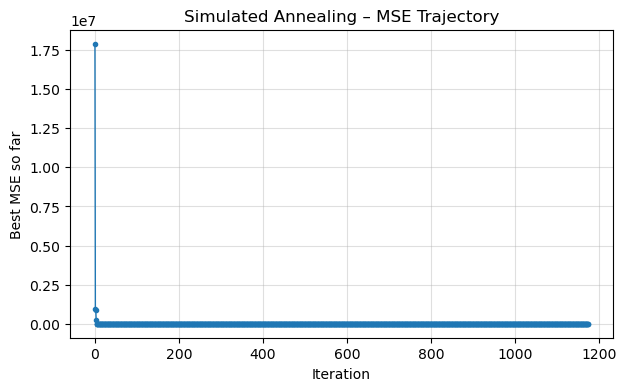

In [58]:
from collections import defaultdict
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Tracker for MSE trajectory
# ---------------------------------------------------------
def make_tracker():
    history = defaultdict(list)

    def callback(x, f, context):
        # f is the best objective value (MSE) at this iteration
        history["mse"].append(f)
    return history, callback

# ---------------------------------------------------------
# 2. Run once and record MSE trajectory
# ---------------------------------------------------------
history, cb = make_tracker()

res = dual_annealing(
    fitness,
    bounds=bounds,
    maxiter=650,           # reduce if you just want a quick test
    initial_temp=75.0,
    no_local_search=True,
    seed=42,
    callback=cb,
)

mse_traj = np.array(history["mse"])

# ---------------------------------------------------------
# 3. Check coverage over last 10 iterations
# ---------------------------------------------------------
if len(mse_traj) >= 10:
    delta_mse = mse_traj[-10:].max() - mse_traj[-10:].min()
    coverage = (delta_mse < 0.01)
    print(f"ΔMSE over last 10 iterations = {delta_mse:.4g}")
    print("Coverage criterion satisfied?" , coverage)
else:
    print("Not enough iterations to check coverage.")

# ---------------------------------------------------------
# 4. Plot MSE trajectory
# ---------------------------------------------------------
plt.figure(figsize=(7,4))
plt.plot(mse_traj, marker='o', markersize=3, linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Best MSE so far")
plt.title("Simulated Annealing – MSE Trajectory")
plt.grid(True, alpha=0.4)
plt.show()

In [59]:
# Convert trajectory to a DataFrame
df = pd.DataFrame({"SA": mse_traj})

# Save to CSV
df.to_csv("mse_traj.csv", index=False)

print("Saved MSE trajectory to mse_traj.csv")

Saved MSE trajectory to mse_traj.csv
